In [129]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(sf, warn.conflicts = FALSE)
library(tibble, warn.conflicts = FALSE)
library(zeallot, warn.conflicts = FALSE)
library(openxlsx, warn.conflicts = FALSE)

source("src/paths/paths.R")
source("notebooks/integrazioni_regionali/nb_tools/state_avail.R")
source("notebooks/integrazioni_regionali/nb_tools/pairing_procedure.R")
source("src/pairing/matching.R")
source("src/pairing/analysis.R")
source("src/pairing/combining.R")
source("src/analysis/data/quality_check.R")
path.er.base <- file.path(path.ds, "ARPA", "EMILIA-ROMAGNA")
path.er.meta <- file.path(path.er.base, "metadata.parquet")
path.er.input_ds <- file.path(path.er.base, "tables")
path.er.data <- file.path(path.er.base, "dataset")


## Sistemazione dataset

In [50]:
ds <- open_dataset(path.er.input_ds, format = "feather") |>
    mutate(anagrafica = cast(name, utf8()), network = cast(network, utf8()), date = date - as.difftime(agg_period, unit = "secs")) |>
    select(!c(P1, starts_with("level"), name))

### Metadati

In [70]:
# ds |>
#     group_by(network, anagrafica, lon, lat, elevation) |>
#     summarise(start_date = min(date), end_date = max(date)) |>
#     mutate(start_date = as.Date(start_date), end_date = as.Date(end_date), lon = lon / 100000, lat = lat / 100000) |>
#     ungroup() |>
#     collect() |>
#     arrange(network, anagrafica, elevation) |>
#     mutate(identifier = row_number()) |>
#     write_parquet(path.er.meta)

meta <- read_parquet(path.er.meta, as_data_frame = FALSE)

Alcune anagrafiche sono doppie, o per cambio rete o per riposizionamento. Molto poche.

In [4]:
meta |> group_by(anagrafica) |> filter(n() > 1)

Warning message:
"Expression n() > 1 not supported in Arrow; pulling data into R"


network,anagrafica,lon,lat,elevation,start_date,end_date,identifier
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<date>,<date>,<int>
agrmet,Carpineti,10.50865,44.47562,580,2005-12-31,2023-11-09,5
claster,Corniolo,11.79314,43.90708,553,2018-02-27,2023-11-09,49
claster,Villa Ghigi,11.32556,44.47611,203,2018-09-30,2019-02-19,60
simnbo,Villa Ghigi,11.32556,44.47611,203,2022-11-05,2023-11-09,143
simnpr,Carpineti,10.49534,44.46787,594,2005-12-31,2010-03-03,158
spdsra,Corniolo,11.79916,43.90315,476,2012-04-18,2023-11-09,237
spdsra,Corniolo,11.79330,43.92426,735,2005-12-31,2023-11-09,238


Reading layer `geoBoundaries-ITA-ADM1' from data source 
  `/Users/davidenicoli/Local_Workspace/Datasets/geoBoundaries/ITA-ADM1/geoBoundaries-ITA-ADM1.geojson' 
  using driver `GeoJSON'
Simple feature collection with 20 features and 5 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 6.626621 ymin: 35.49285 xmax: 18.52038 ymax: 47.09178
Geodetic CRS:  WGS 84


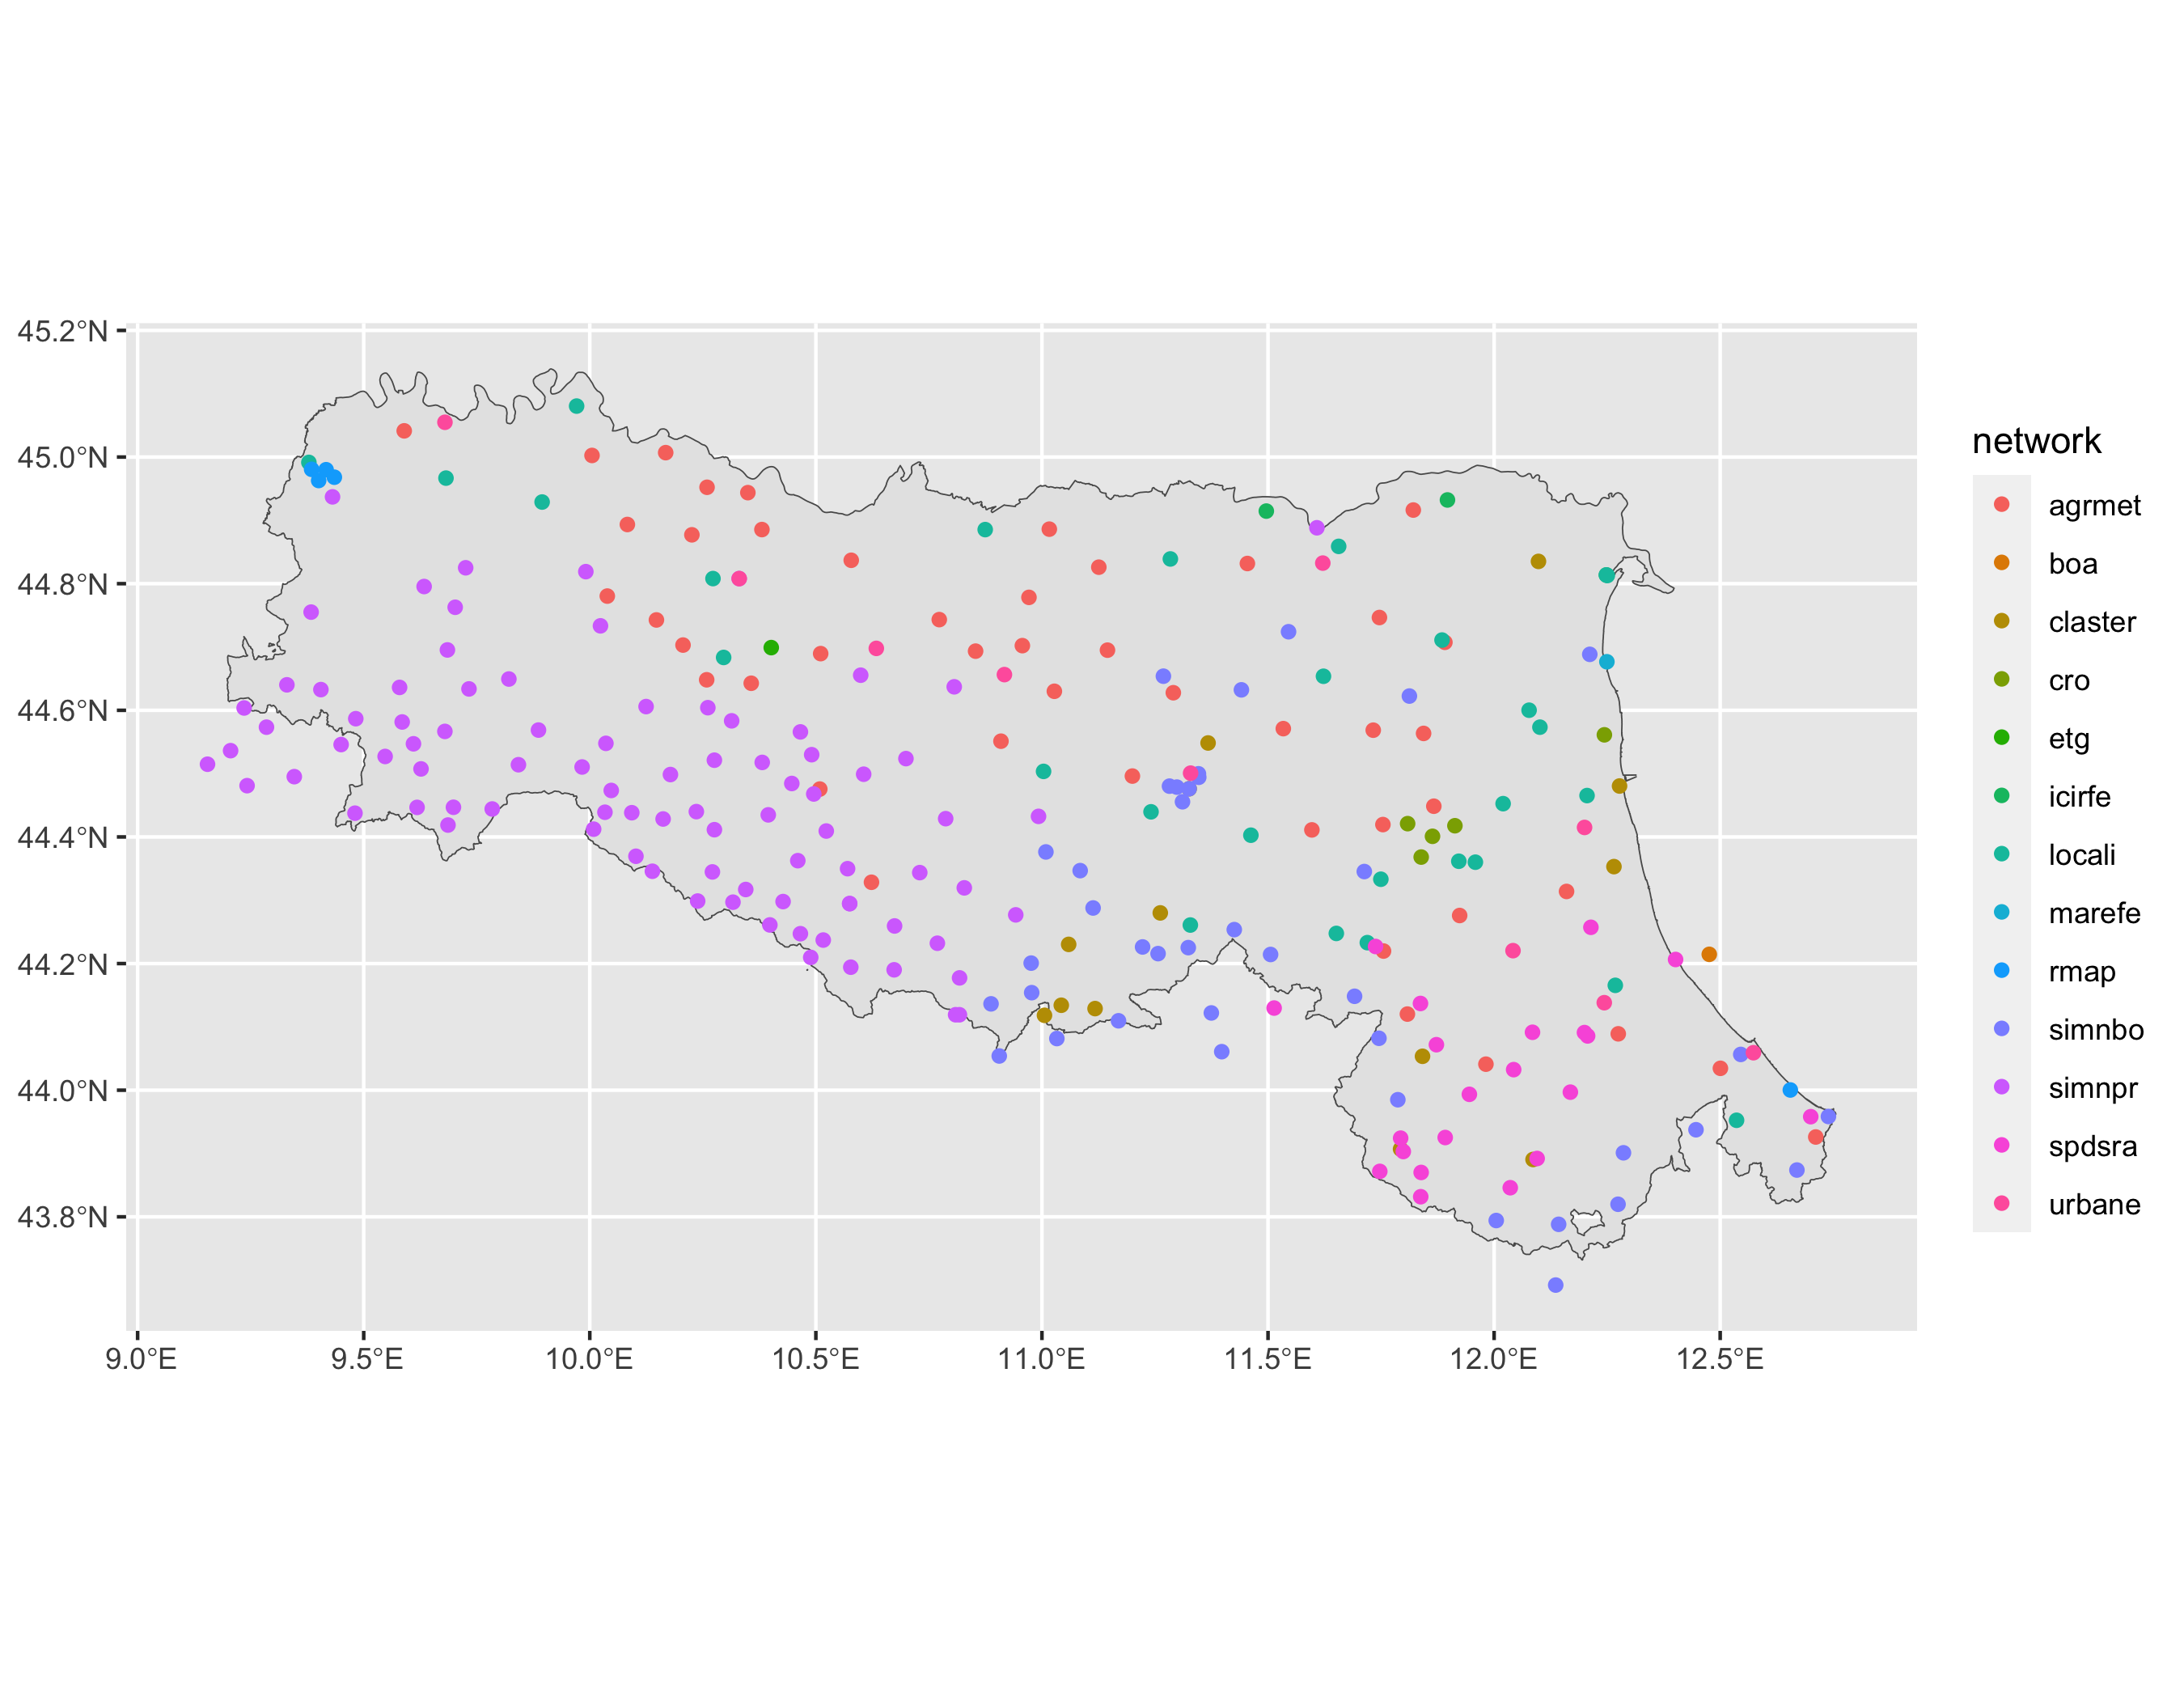

In [6]:
erb <- load.italian_boundaries("state") |> filter(shapeName == "Emilia-Romagna")
ggplot() +
    geom_sf(data = erb) +
    geom_sf(data = meta |> collect() |> st_md_to_sf(), aes(color = network))

### Dati

Inizio con un'aggregazione "globale", dopo i confronti con SCIA vedrò se è meglio fare separatamente sui valori di aggregazione statistica

In [66]:
# QC: fatto anche quello sui valori ripetuti ma non cene sono
# ds |> left_join(select(meta, network, anagrafica, elevation, identifier), by = c("network", "anagrafica", "elevation")) |>
#     group_by(identifier, date = as.Date(date)) |>
#     mutate(T = T - 273.15) |>
#     gross_errors_check(T) |>
#     filter(!qc_gross) |>
#     summarise(T_MIN = min(T, na.rm = TRUE), T_MAX = max(T, na.rm = TRUE)) |> 
#     ungroup() |>
#     arrange(identifier, date) |> collect() |>
#     pivot_longer(c(T_MIN, T_MAX), names_to = "variable") |>
#     write_dataset(path.er.data, format = "feather", partitioning = "variable")

data <- open_dataset(path.er.data, format = "feather")

In [9]:
scia <- open_db_state_data("SCIA", "Emilia-Romagna")
dpc <- open_db_state_data("BRUN", "Emilia-Romagna")


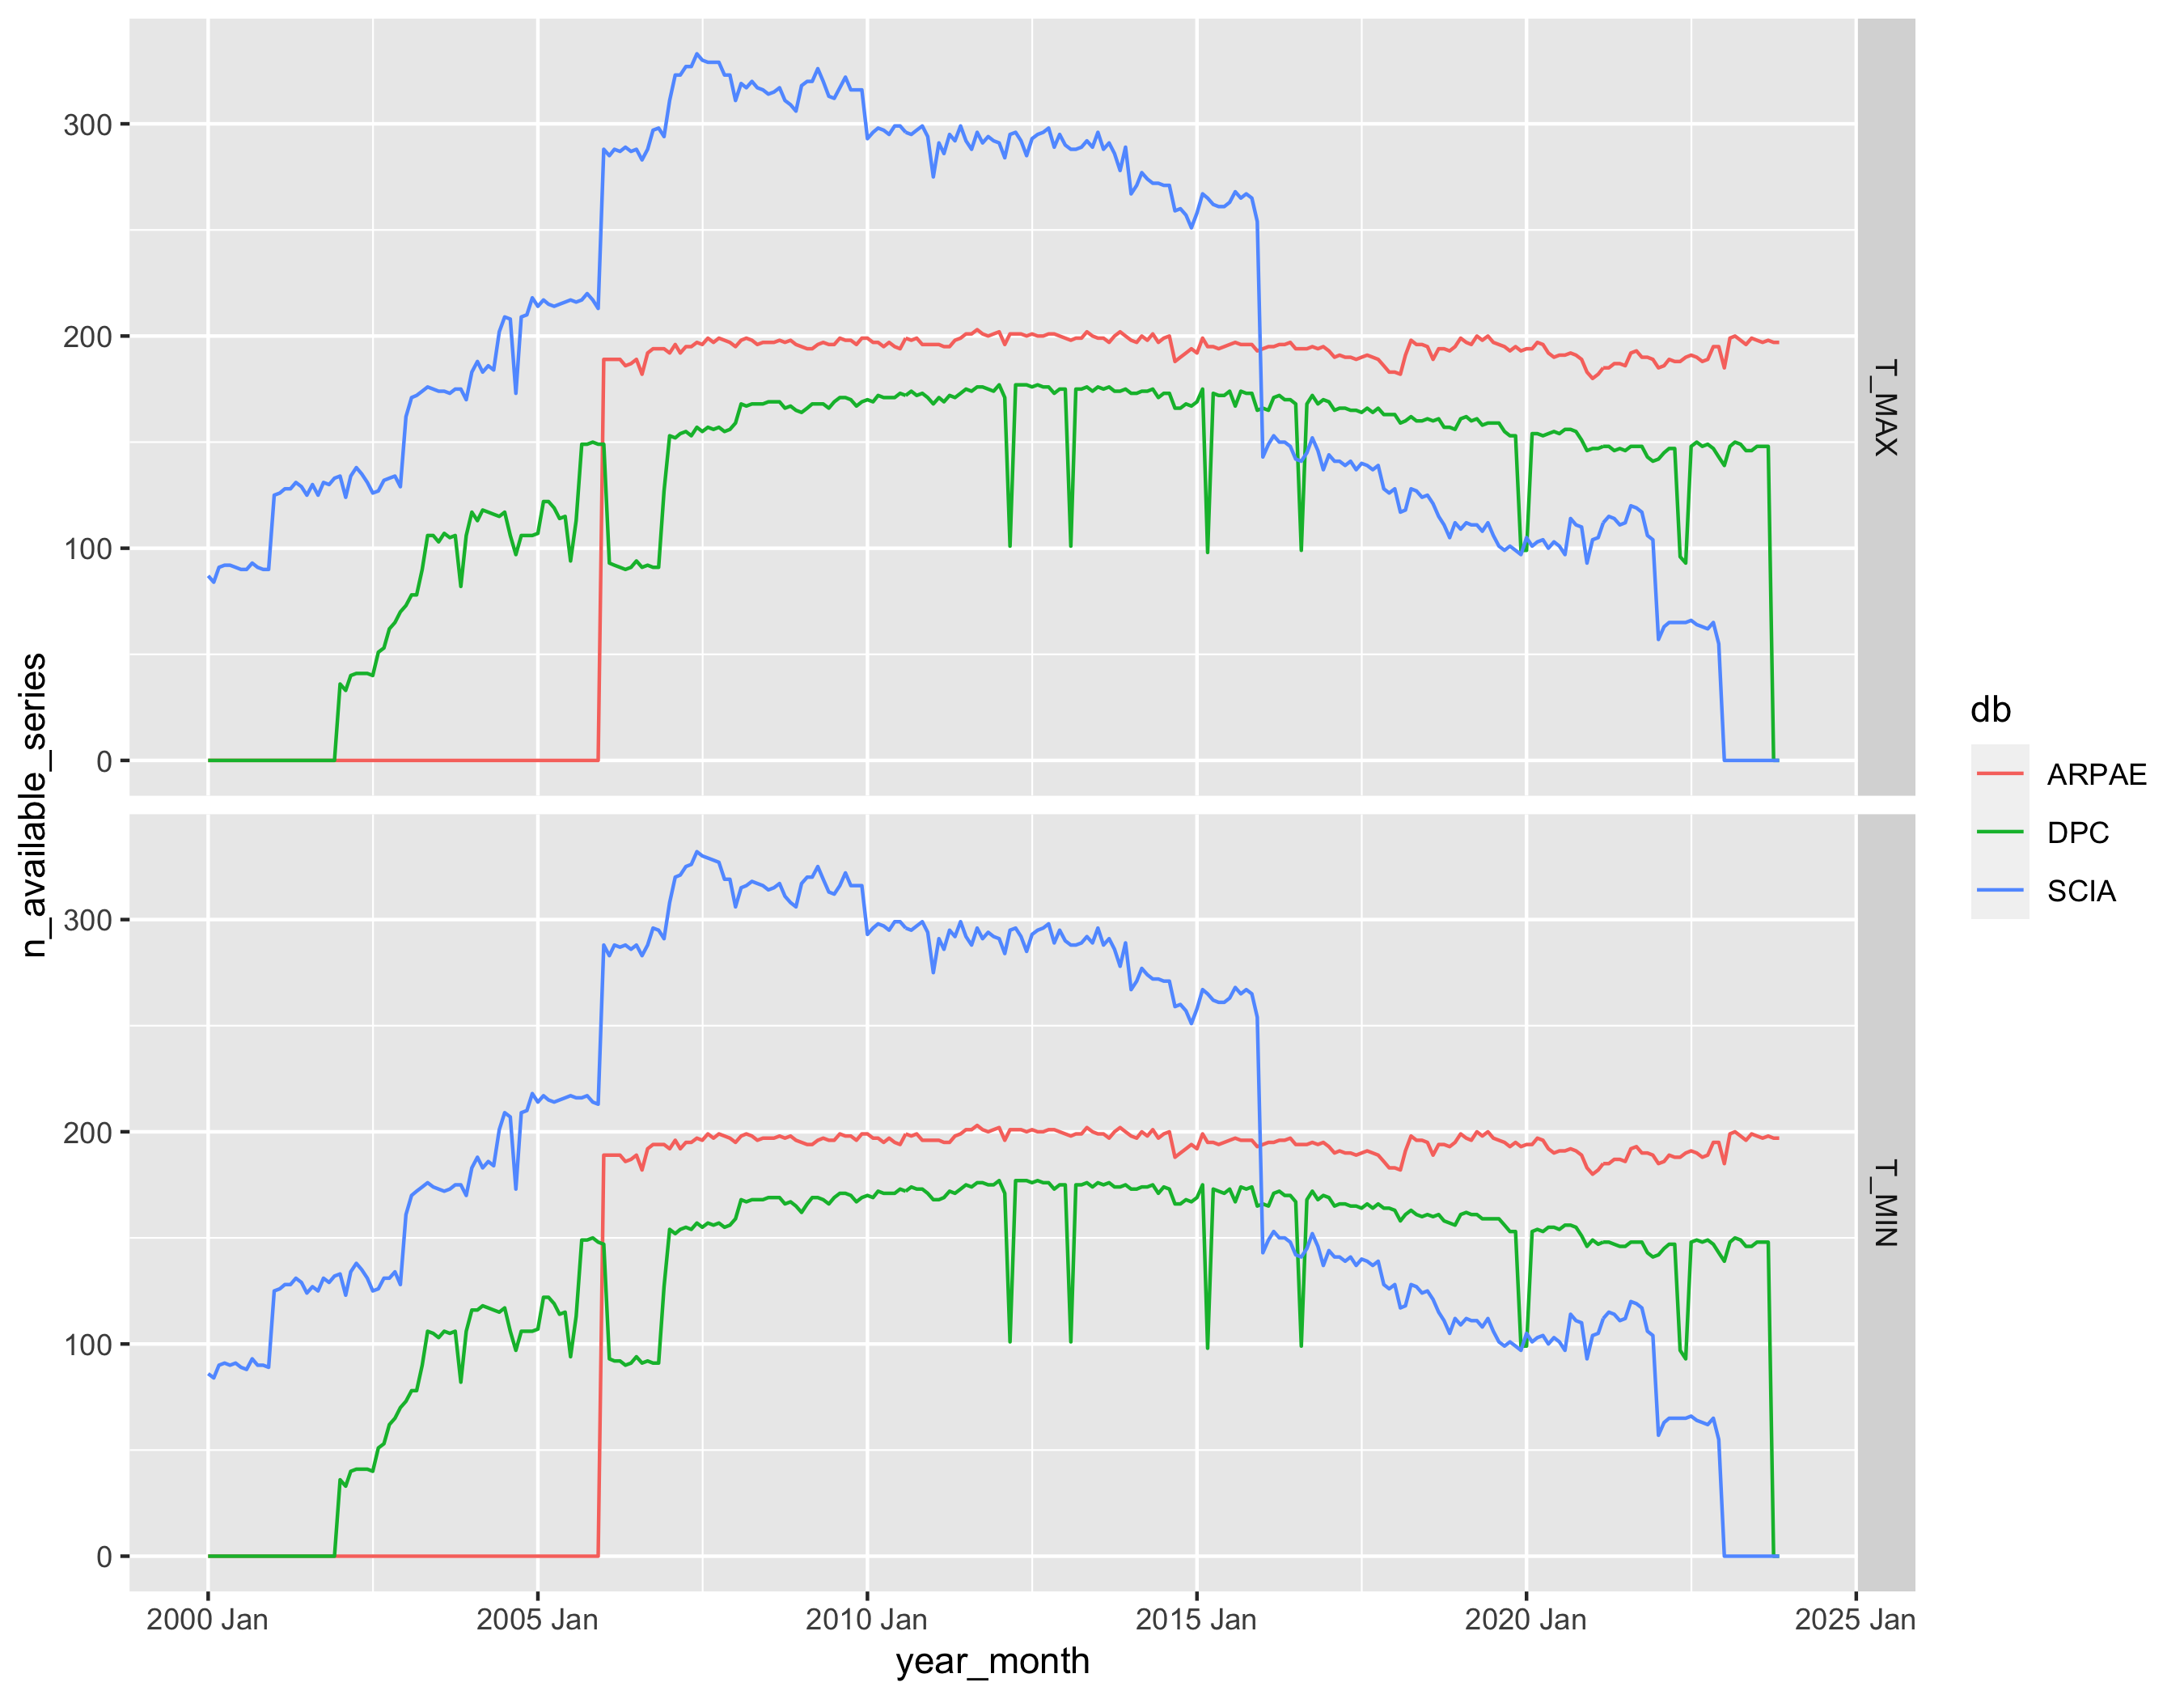

In [10]:
library(stringr)
plot_state_avail(bind_rows(
    SCIA = scia,
    DPC = dpc,
    ARPAE = data |> mutate(identifier = as.character(identifier)) |> collect(),
    .id = "db"
))


In [74]:
md.scia <- open.dataset("SCIA", "metadata") |> filter(state == "Emilia-Romagna")
data.scia <- open.dataset("SCIA", "data") |> semi_join(md.scia, by = "identifier")
md.scia <- collect(md.scia)
meta <- collect(meta)
meta <- bind_rows(T_MIN = meta, T_MAX = meta, .id = "variable")

In [111]:
matches <- matches_table(meta |> st_md_to_sf(), md.scia |> st_md_to_sf(), 2)
c(er.tmax, er.tmin) %<-% widen_split_data(data, matches, identifier.x, as.Date("2001-01-01"))
c(scia.tmax, scia.tmin) %<-% widen_split_data(data.scia, matches, identifier.y, as.Date("2001-01-01"))
analysis <- build_analysis(matches, er.tmin, er.tmax, scia.tmin, scia.tmax)

In [112]:
analysis |>
    select(variable, starts_with("ident"), starts_with("anagrafica"), network, rete, distance, f0, fsemiside, delH, delT, maeT, monthlydelT, minilap, starts_with("valid_days_"), all_filter) |>
    write.xlsx("er_matches.xlsx")


Warning message:
"Removed 6791 rows containing missing values (`geom_line()`)."


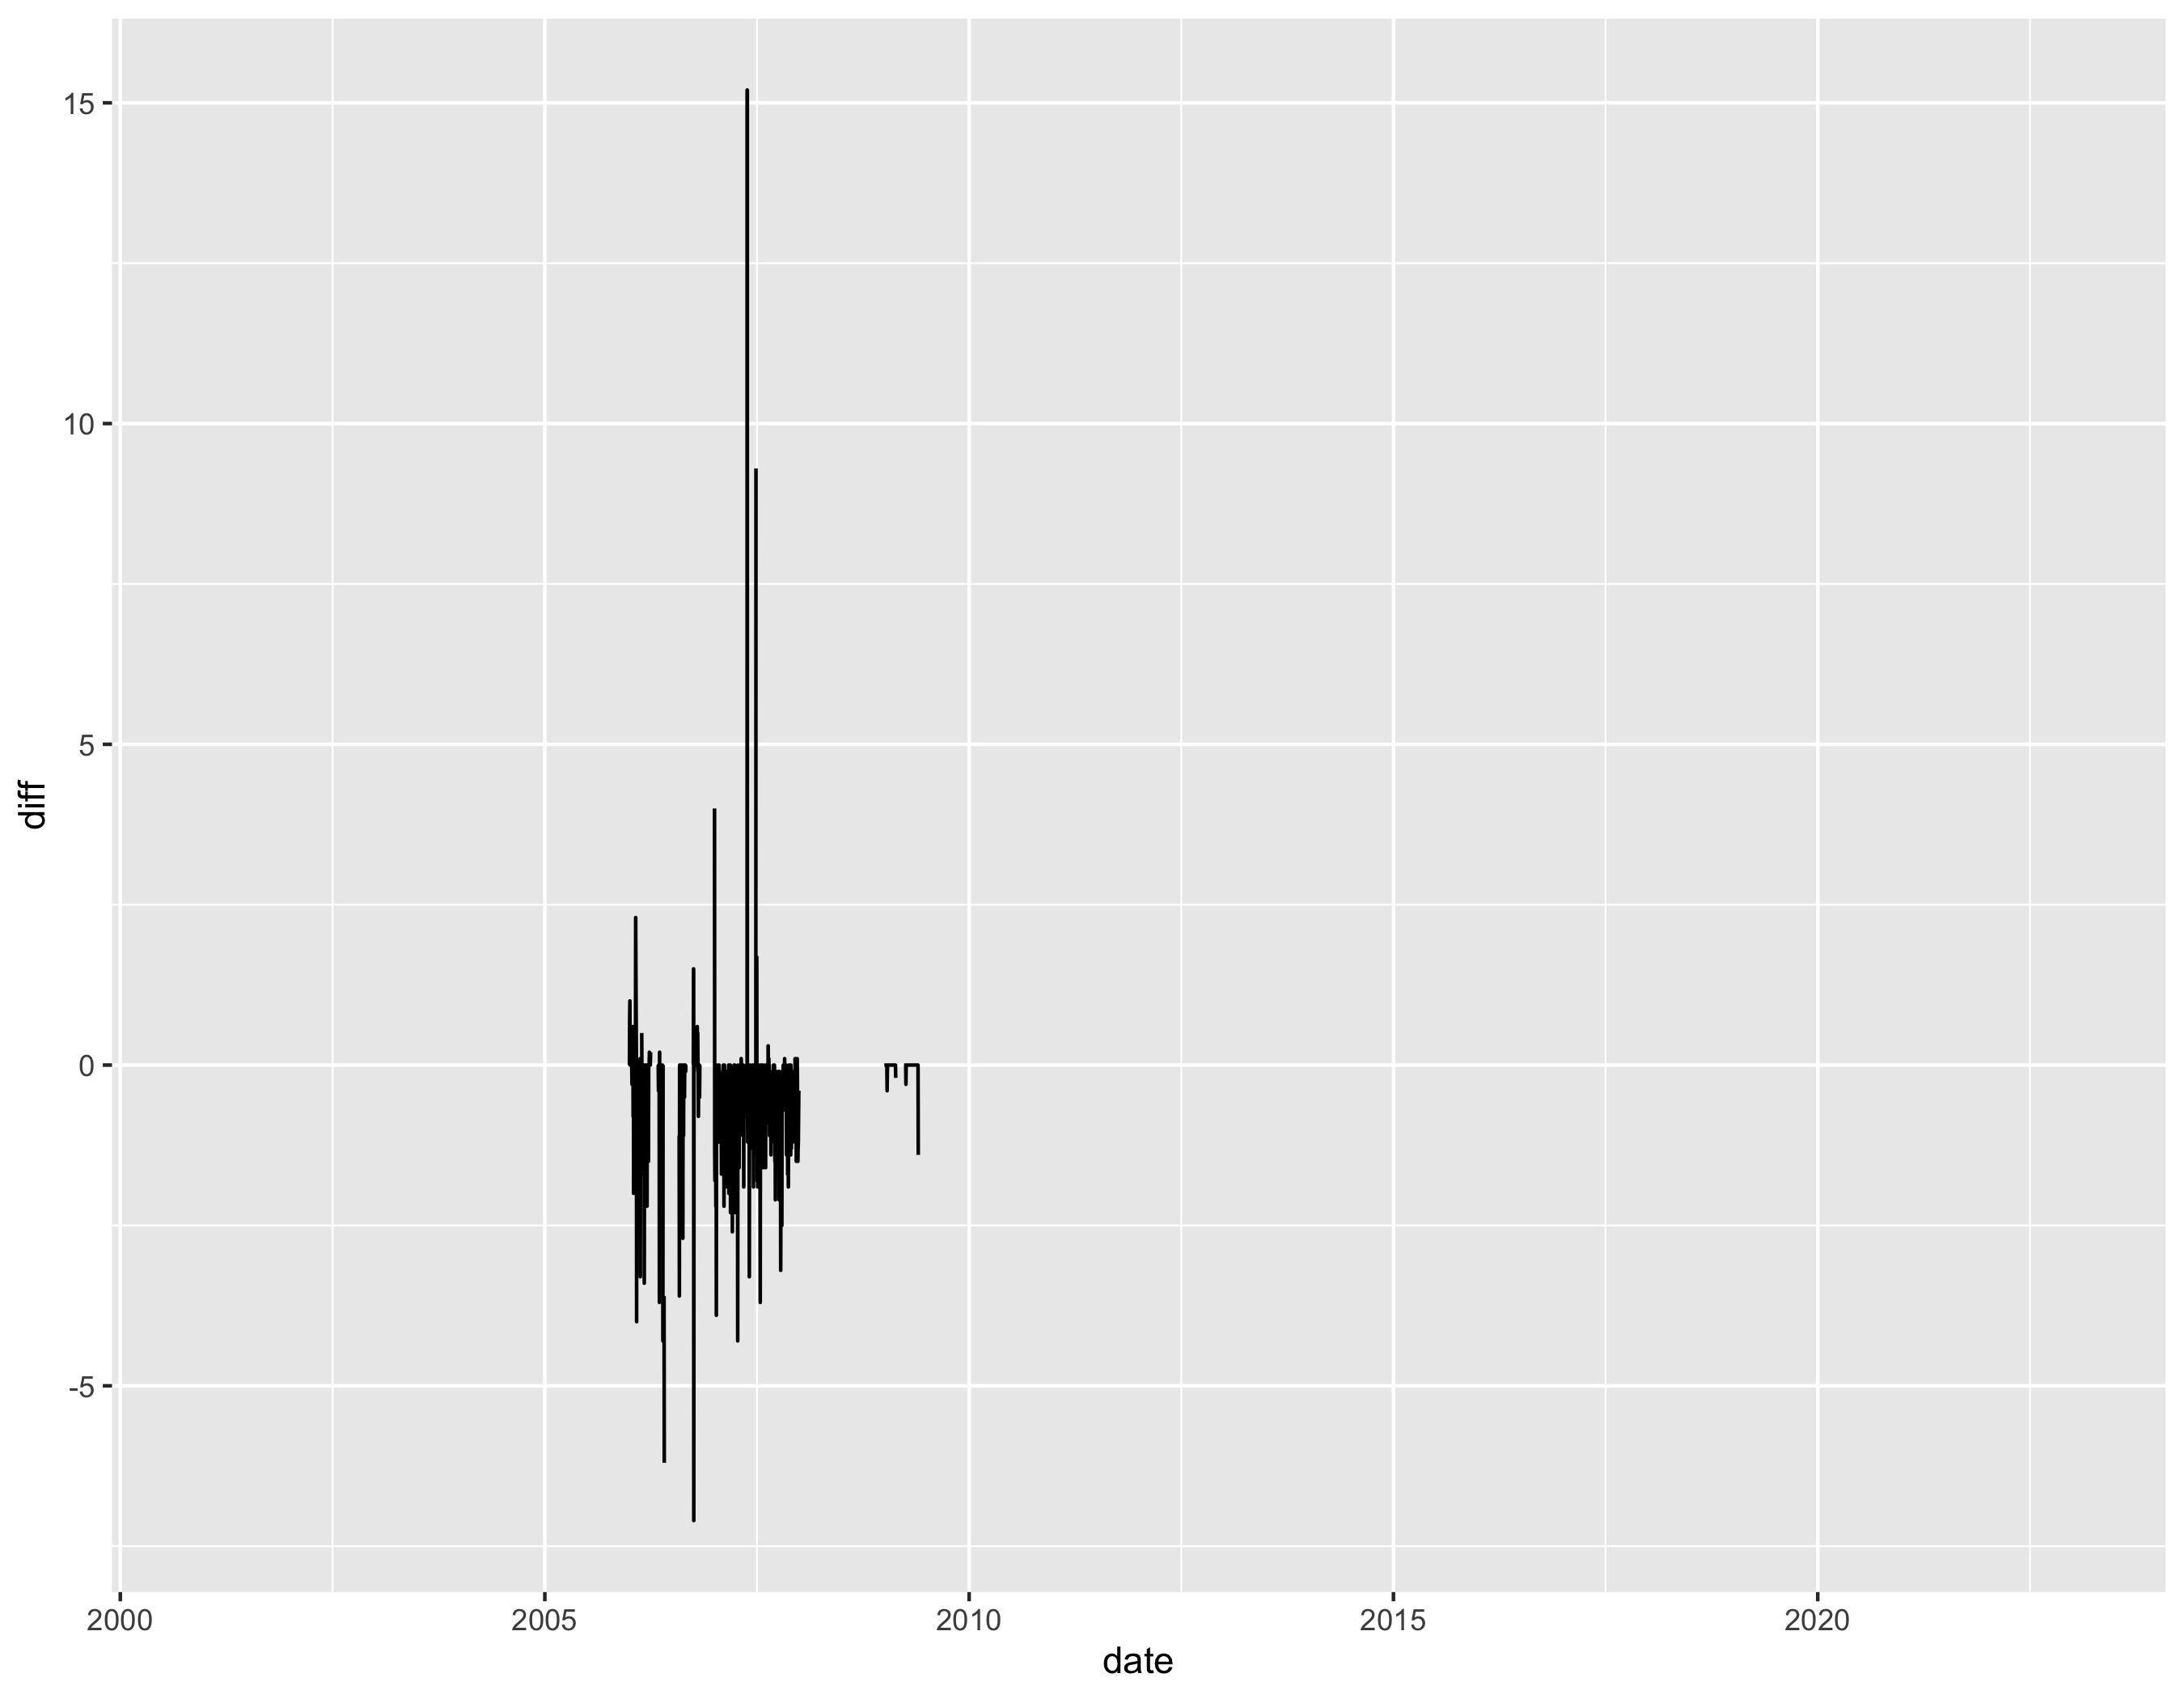

In [109]:
s1 <- er.tmin$`135`
s2 <- scia.tmin$`9352`
bind_cols(ARPAE = s1, SCIA = s2, date = er.tmax$date) |>
    mutate(diff = ARPAE - SCIA) |>
    ggplot(aes(date, diff)) + geom_line()
    # pivot_longer(c(ARPAE, SCIA)) |>
    # ggplot(aes(date, value, color = name)) + geom_line()

In [117]:
hard_filters <- function(data) {
    # Based on manual checks
    data |> mutate(
        hard_filter = abs(delT) <= 0.4
        # ((is.na(delH) & delZ < 150) | delH <= 150)
    )
}

sure_filters <- function(data) {
    data |> mutate(
        sure_match = (
            (distance <= 100 & (is.na(delH) | delH <= 50)) |
                (distance < 50) |
                (f0 >= 0.3 & valid_days_inters * f0 > 100) |
                (f0 >= 0.07 & abs(delT) <= 0.45)
        )
    )
}

very_good_filters <- function(data) {
    # Very good matches
    data |> mutate(
        very_good_match = (distance <= 500 & delH <= 100) & (f0 > 0.05 & valid_days_inters * f0 >= 30) & (abs(monthlydelT) <= 0.4)
    )
}


results.1 <- analysis |>
    hard_filters() |>
    sure_filters() |>
    very_good_filters()

# Sure matches. I take these as given and remove them from the match list. Some of them are duplicated both in scia and dpc; in any case I remove them from the master list as a whole.
sure_matches <- results.1 |>
    filter(sure_match)
sure_matches.by_same_station <- results.1 |>
    semi_join(sure_matches, by = join_by(identifier.x, identifier.y), na_matches = "never") |>
    anti_join(sure_matches, by = c("variable", "identifier.x", "identifier.y"))

# Surely match and respect hard filters
matchlist <- bind_rows(sure_matches, sure_matches.by_same_station) |> filter(hard_filter)

results.unsure <- results.1 |> clean_from(matchlist) |> filter(hard_filter)

# Attenzione: sono ancora presenti duplicati; basta prendere l'f0 max
matchlist |>
    filter(all_filter, hard_filter) |>
    group_by(identifier.x) |>
    n_groups()


[1] 357

In [114]:
matchlist |> group_by(identifier.x) |> filter(n() > 1) |>
    select(variable, starts_with("ident"), starts_with("anagrafica"), network, rete, distance, f0, fsemiside, delH, delT, maeT, monthlydelT, minilap, starts_with("valid_days_"), all_filter) |> arrange(f0)

variable,identifier.x,identifier.y,anagrafica.x,anagrafica.y,network,rete,distance,f0,fsemiside,delH,delT,maeT,monthlydelT,minilap,valid_days_inters,valid_days_union,all_filter
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<lgl>
T_MAX,102,14477,Verago,Verago,rmap,RETE EMILIA ROMAGNA OPENDATA,1.867121e-01,0.05357143,1,NA,0.005178543,0.03017850,0.060516973,1.0000000,168,806,FALSE
T_MIN,51,9276,Diga di Pavana,PAVANADIGA,claster,Idrografica,5.675689e+00,0.06853583,1,7,0.327881624,0.60904468,0.069982685,0.6129854,963,7768,TRUE
T_MAX,50,9064,Diga di Brasimone,BRASIMONEDIGA,claster,Idrografica,3.034852e+01,0.06935818,1,116,-0.344347839,0.47086958,-0.488490611,0.5510553,966,7251,TRUE
T_MIN,20,9565,Grugno,Grugno,agrmet,Idrografica,3.493496e+02,0.07162534,1,1,-0.364738282,0.36914601,-0.366362708,1.0000000,363,3706,FALSE
T_MAX,55,9210,Marina di Ravenna,MARINADIRAVENNA,claster,Idrografica,1.273478e+03,0.07341270,1,NA,0.007242063,0.02835322,0.017388701,0.3689605,504,6381,TRUE
T_MAX,51,9276,Diga di Pavana,PAVANADIGA,claster,Idrografica,5.675689e+00,0.07684320,1,7,0.264766350,0.86098652,0.098097466,0.6129854,963,7778,TRUE
T_MIN,52,14236,Diga di Quarto,Diga di Quarto,claster,RETE EMILIA ROMAGNA OPENDATA,1.907202e-02,0.07707911,1,NA,0.011298185,0.02813390,0.107495878,1.0000000,493,1376,FALSE
T_MIN,244,14236,Quarto,Diga di Quarto,spdsra,RETE EMILIA ROMAGNA OPENDATA,7.479917e+02,0.07723577,1,NA,-0.126016250,0.48577236,-0.116529734,0.9979716,492,6174,TRUE
T_MIN,55,9210,Marina di Ravenna,MARINADIRAVENNA,claster,Idrografica,1.273478e+03,0.07738095,1,NA,0.004642871,0.02527778,0.065479342,0.3689605,504,6374,TRUE


In [38]:
merged.tmin <- matchlist |>
    filter(variable == "T_MIN", all_filter) |>
    ungroup() |>
    group_by(identifier.x) |>
    slice_max(f0) |>
    slice_min(delZ) |>
    ungroup() |>
    update_left(er.tmin, scia.tmin) |>
    left_join(yes_common_data |> select(match_id, identifier.x) |> rename(identifier = identifier.x) |> mutate(match_id = as.character(match_id)), by = "match_id") |>
    mutate(variable = "T_MIN") |>
    select(identifier, variable, date, value)


# merged.tmin |> ggplot(aes(date, value, color = match_id)) +
#     geom_line(show.legend = FALSE)


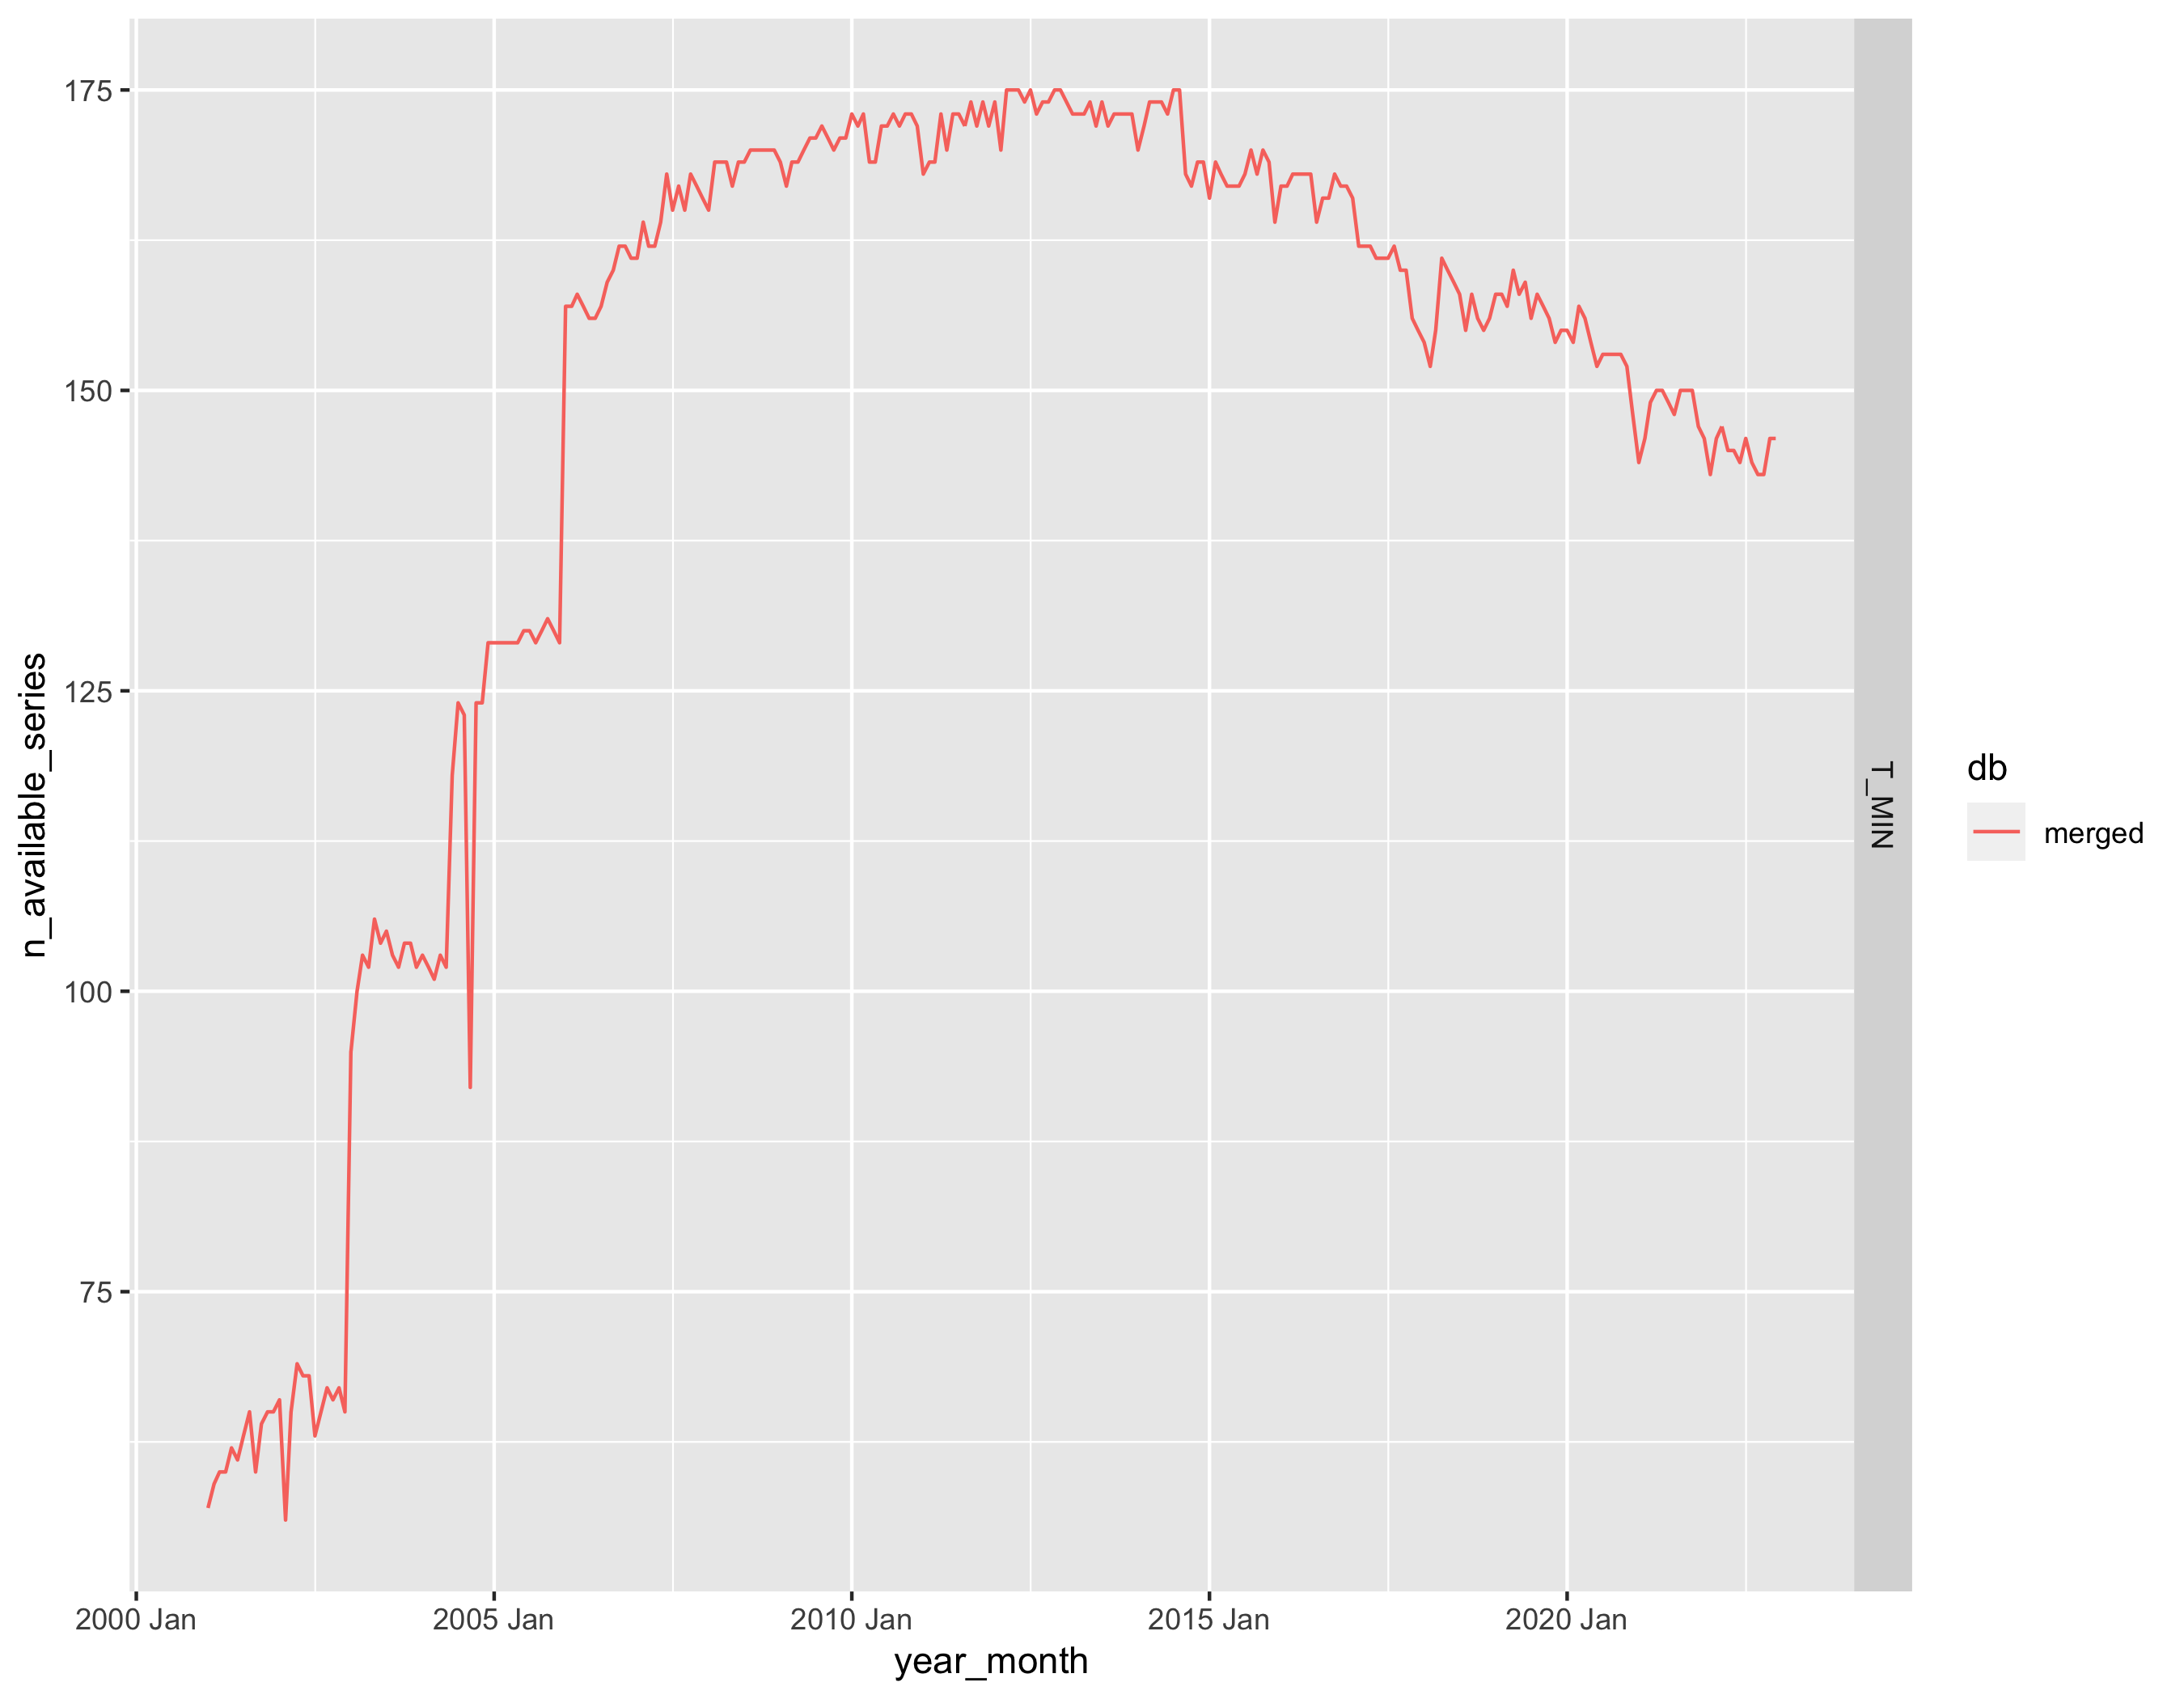

In [39]:
plot_state_avail(merged.tmin |> mutate(variable = "T_MIN", db = "merged"))


In [130]:
merged.tmin <- update_left(matchlist |> filter(variable == "T_MIN"), er.tmin, scia.tmin)

Warning message in predict.lm(model, ts):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"


In [150]:
merged.tmin

identifier.x,value,date,identifier,original_value
<chr>,<dbl>,<date>,<chr>,<lgl>
1,-5.1002813776,2001-01-01,1,FALSE
1,-0.0002648588,2001-01-02,1,FALSE
1,-2.0002487095,2001-01-03,1,FALSE
1,-2.6002329451,2001-01-04,1,FALSE
1,-1.4002178429,2001-01-05,1,FALSE
1,1.7997967494,2001-01-06,1,FALSE
1,2.7998108893,2001-01-07,1,FALSE
1,3.4998245393,2001-01-08,1,FALSE
1,1.1998376388,2001-01-09,1,FALSE


Warning message:
"Removed 324 rows containing missing values (`geom_path()`)."


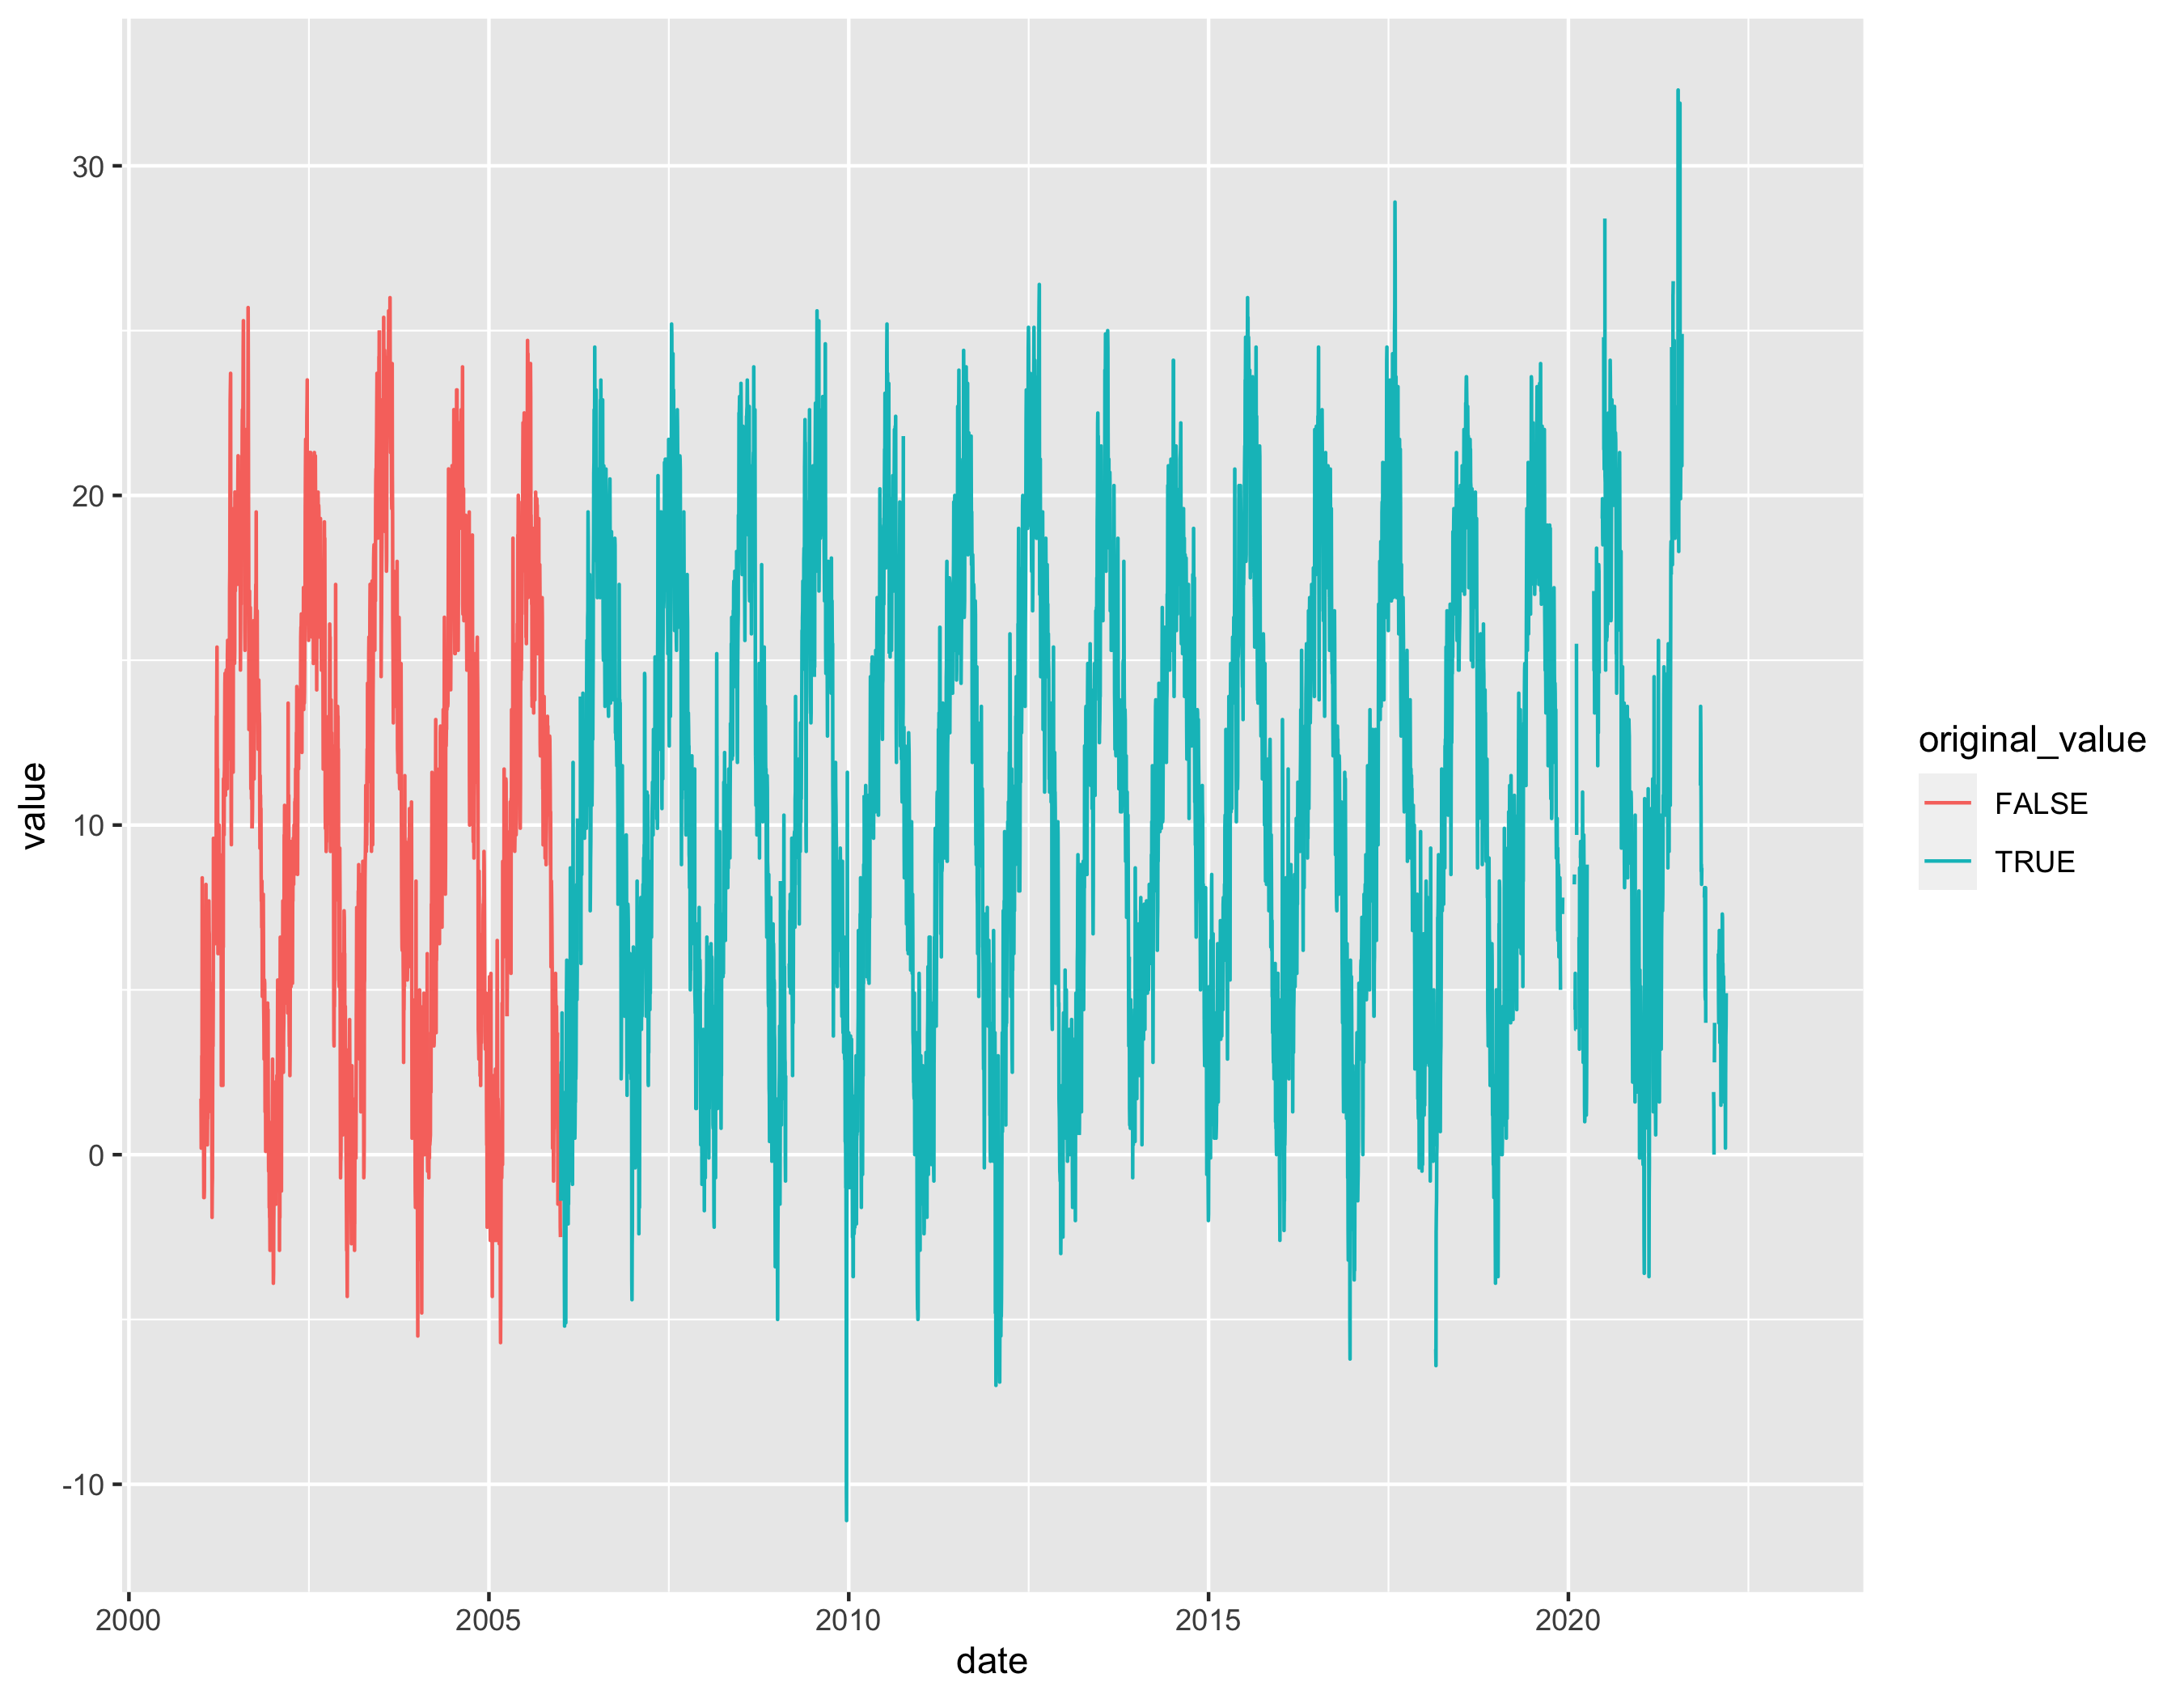

In [135]:
merged.tmin |> filter(identifier.x == "4") |> ggplot(aes(date, value, color = original_value)) + geom_path()

In [146]:
emilia.tmin <- anti_join(data, merged.tmin |> mutate(identifier = as.integer(identifier)) |> as_arrow_table(), by = "identifier") |> filter(variable == "T_MIN") |> collect()
sscia.tmin <- anti_join(data.scia, matchlist |> as_arrow_table() |> mutate(identifier = cast(identifier.y, uint32())), by = "identifier") |> filter(variable == "T_MIN") |> collect()

In [158]:
tot <- bind_rows(merged.tmin |> select(identifier, value, date) |> mutate(variable = "T_MIN", identifier = str_c("merged_",identifier)), emilia.tmin |> mutate(identifier = str_c("er_", identifier)), sscia.tmin |> mutate(identifier = str_c("sc_", identifier)))

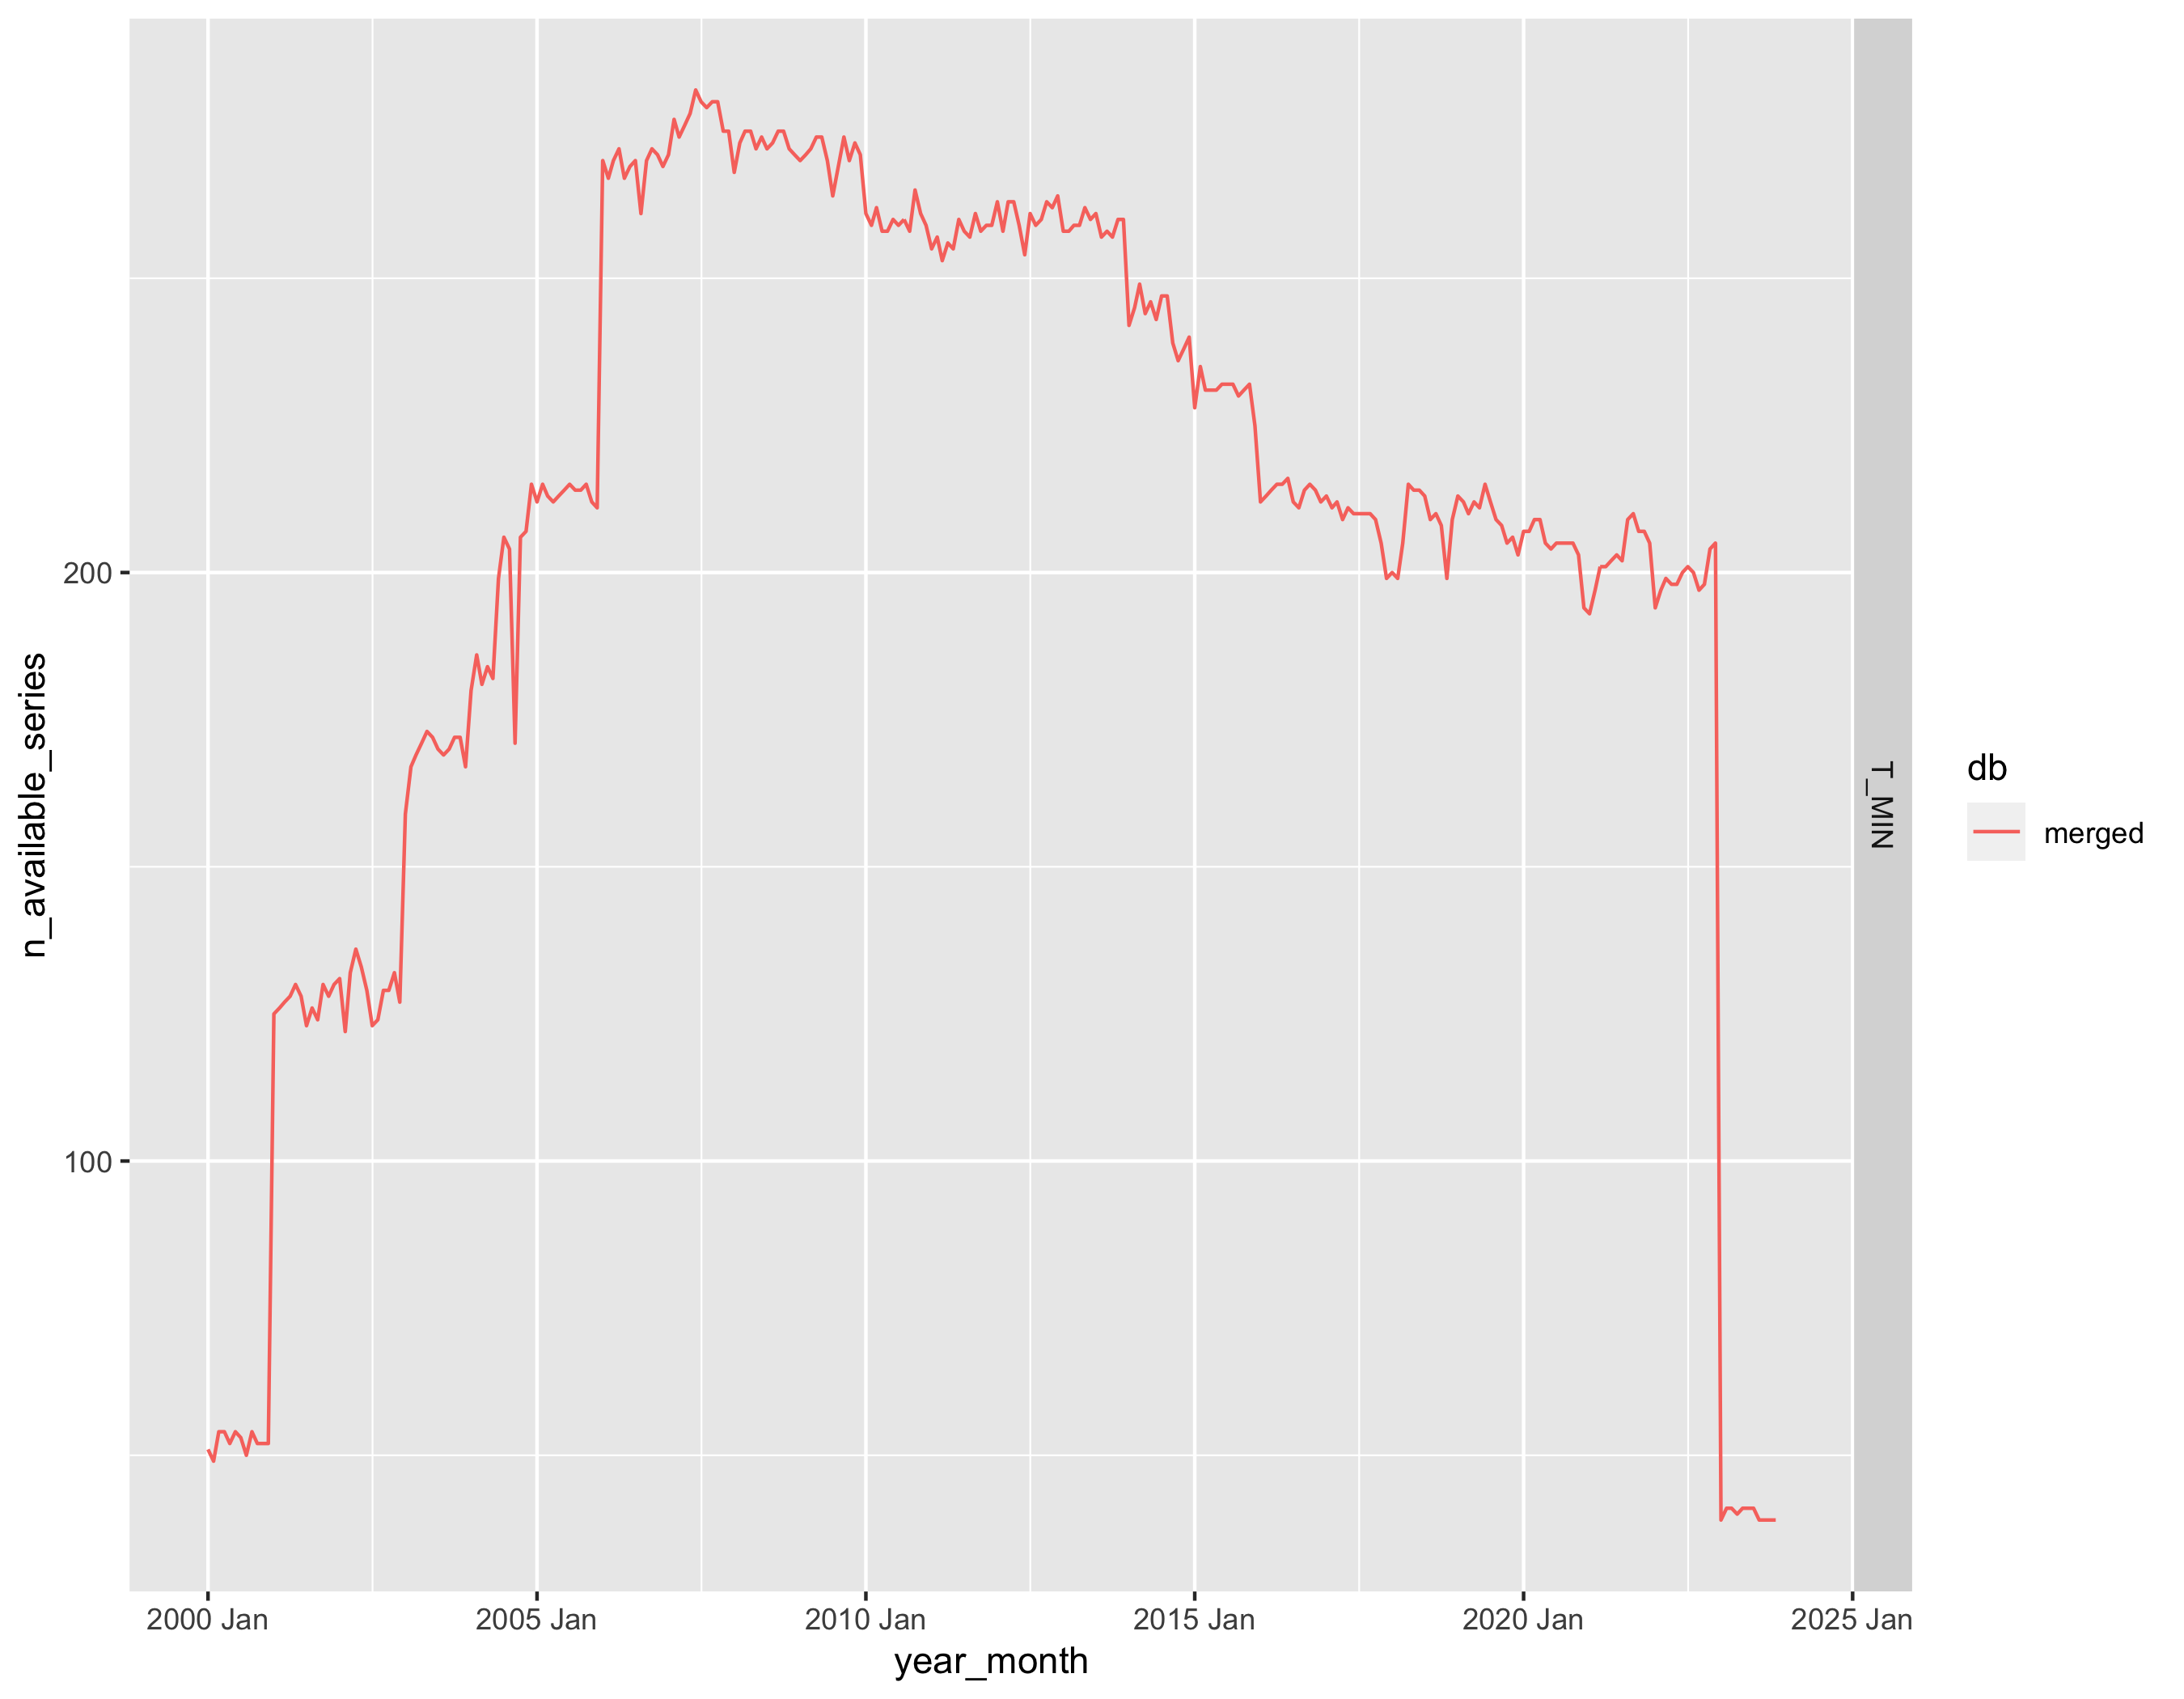

In [159]:
plot_state_avail(tot |> mutate(db = "merged"))

In [217]:
mtch |> select(starts_with("identi"), anagrafica.x, network, match_id, variable)


identifier.x,identifier.y,anagrafica.x,network,match_id,variable
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
205,9142,Cusercoli,agrmet,316,T_MIN
205,7104,Cusercoli,agrmet,317,T_MIN


In [210]:
idx <- "205"
idy1 <- "9142"
idy2 <- "7104"
m1 <- "316"
m2 <- "317"
mtch <- filter(matchlist, identifier.x == idx)
er.tmin_ <- mutate(er.tmin, t = compute_ts(date)) |>
    as_tibble() |>
    arrange(date)
scia.tmin_ <- as_tibble(scia.tmin) |> as_tibble()
corrections <- diffs_table(mtch, er.tmin_, scia.tmin_) |>
    monthly_corrections() |>
    prepare_for_modeling() |>
    group_by(match_id) |>
    group_modify(~ model_and_predict_corrections(., er.tmin_ |> select(t, date))) |>
    pivot_wider(id_cols = date, names_from = match_id, values_from = correction) |>
    arrange(date) |>
    select(-date)


In [211]:
repl_values <- select(scia.tmin_, mtch$identifier.y, date)
corrs <- select(corrections, mtch$match_id)


vals <- coalesce_group(idx, mtch$identifier.y, mtch$match_id, er.tmin_, scia.tmin_, corrections)


In [213]:
proc <- tibble(final = vals, orig = pull(er.tmin_, idx), repl1 = pull(scia.tmin_, idy1), repl2 = pull(scia.tmin_, idy2), corr1 = pull(corrections, m1), corr2 = pull(corrections, m2), date = er.tmin_$date)


In [216]:
proc |>
    filter(!is.na(orig)) |>
    mutate(c1 = repl1 + corr1, c2 = repl2 + corr2)


final,orig,repl1,repl2,corr1,corr2,date,c1,c2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<dbl>,<dbl>
-2.2,-2.2,-2.2,-2.2,-0.7833533,-0.7274305,2006-01-01,-2.9833533,-2.9274305
-2.2,-2.2,0.1,0.1,-0.7823536,-0.7260294,2006-01-02,-0.6823536,-0.6260294
0.1,0.1,1.9,1.9,-0.7813701,-0.7246447,2006-01-03,1.1186299,1.1753552
1.4,1.4,1.4,1.4,-0.7804023,-0.7232766,2006-01-04,0.6195976,0.6767234
1.4,1.4,1.4,1.4,-0.7794499,-0.7219251,2006-01-05,0.6205500,0.6780749
1.2,1.2,NA,NA,-0.7785125,-0.7205901,2006-01-06,NA,NA
2.4,2.4,NA,NA,-0.7775895,-0.7192718,2006-01-07,NA,NA
1.5,1.5,1.1,1.1,-0.7766805,-0.7179701,2006-01-08,0.3233195,0.3820299
0.0,0.0,NA,-0.3,-0.7757851,-0.7166850,2006-01-09,NA,-1.0166850


Warning message:
"Removed 15766 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 5947 rows containing missing values (`geom_point()`)."


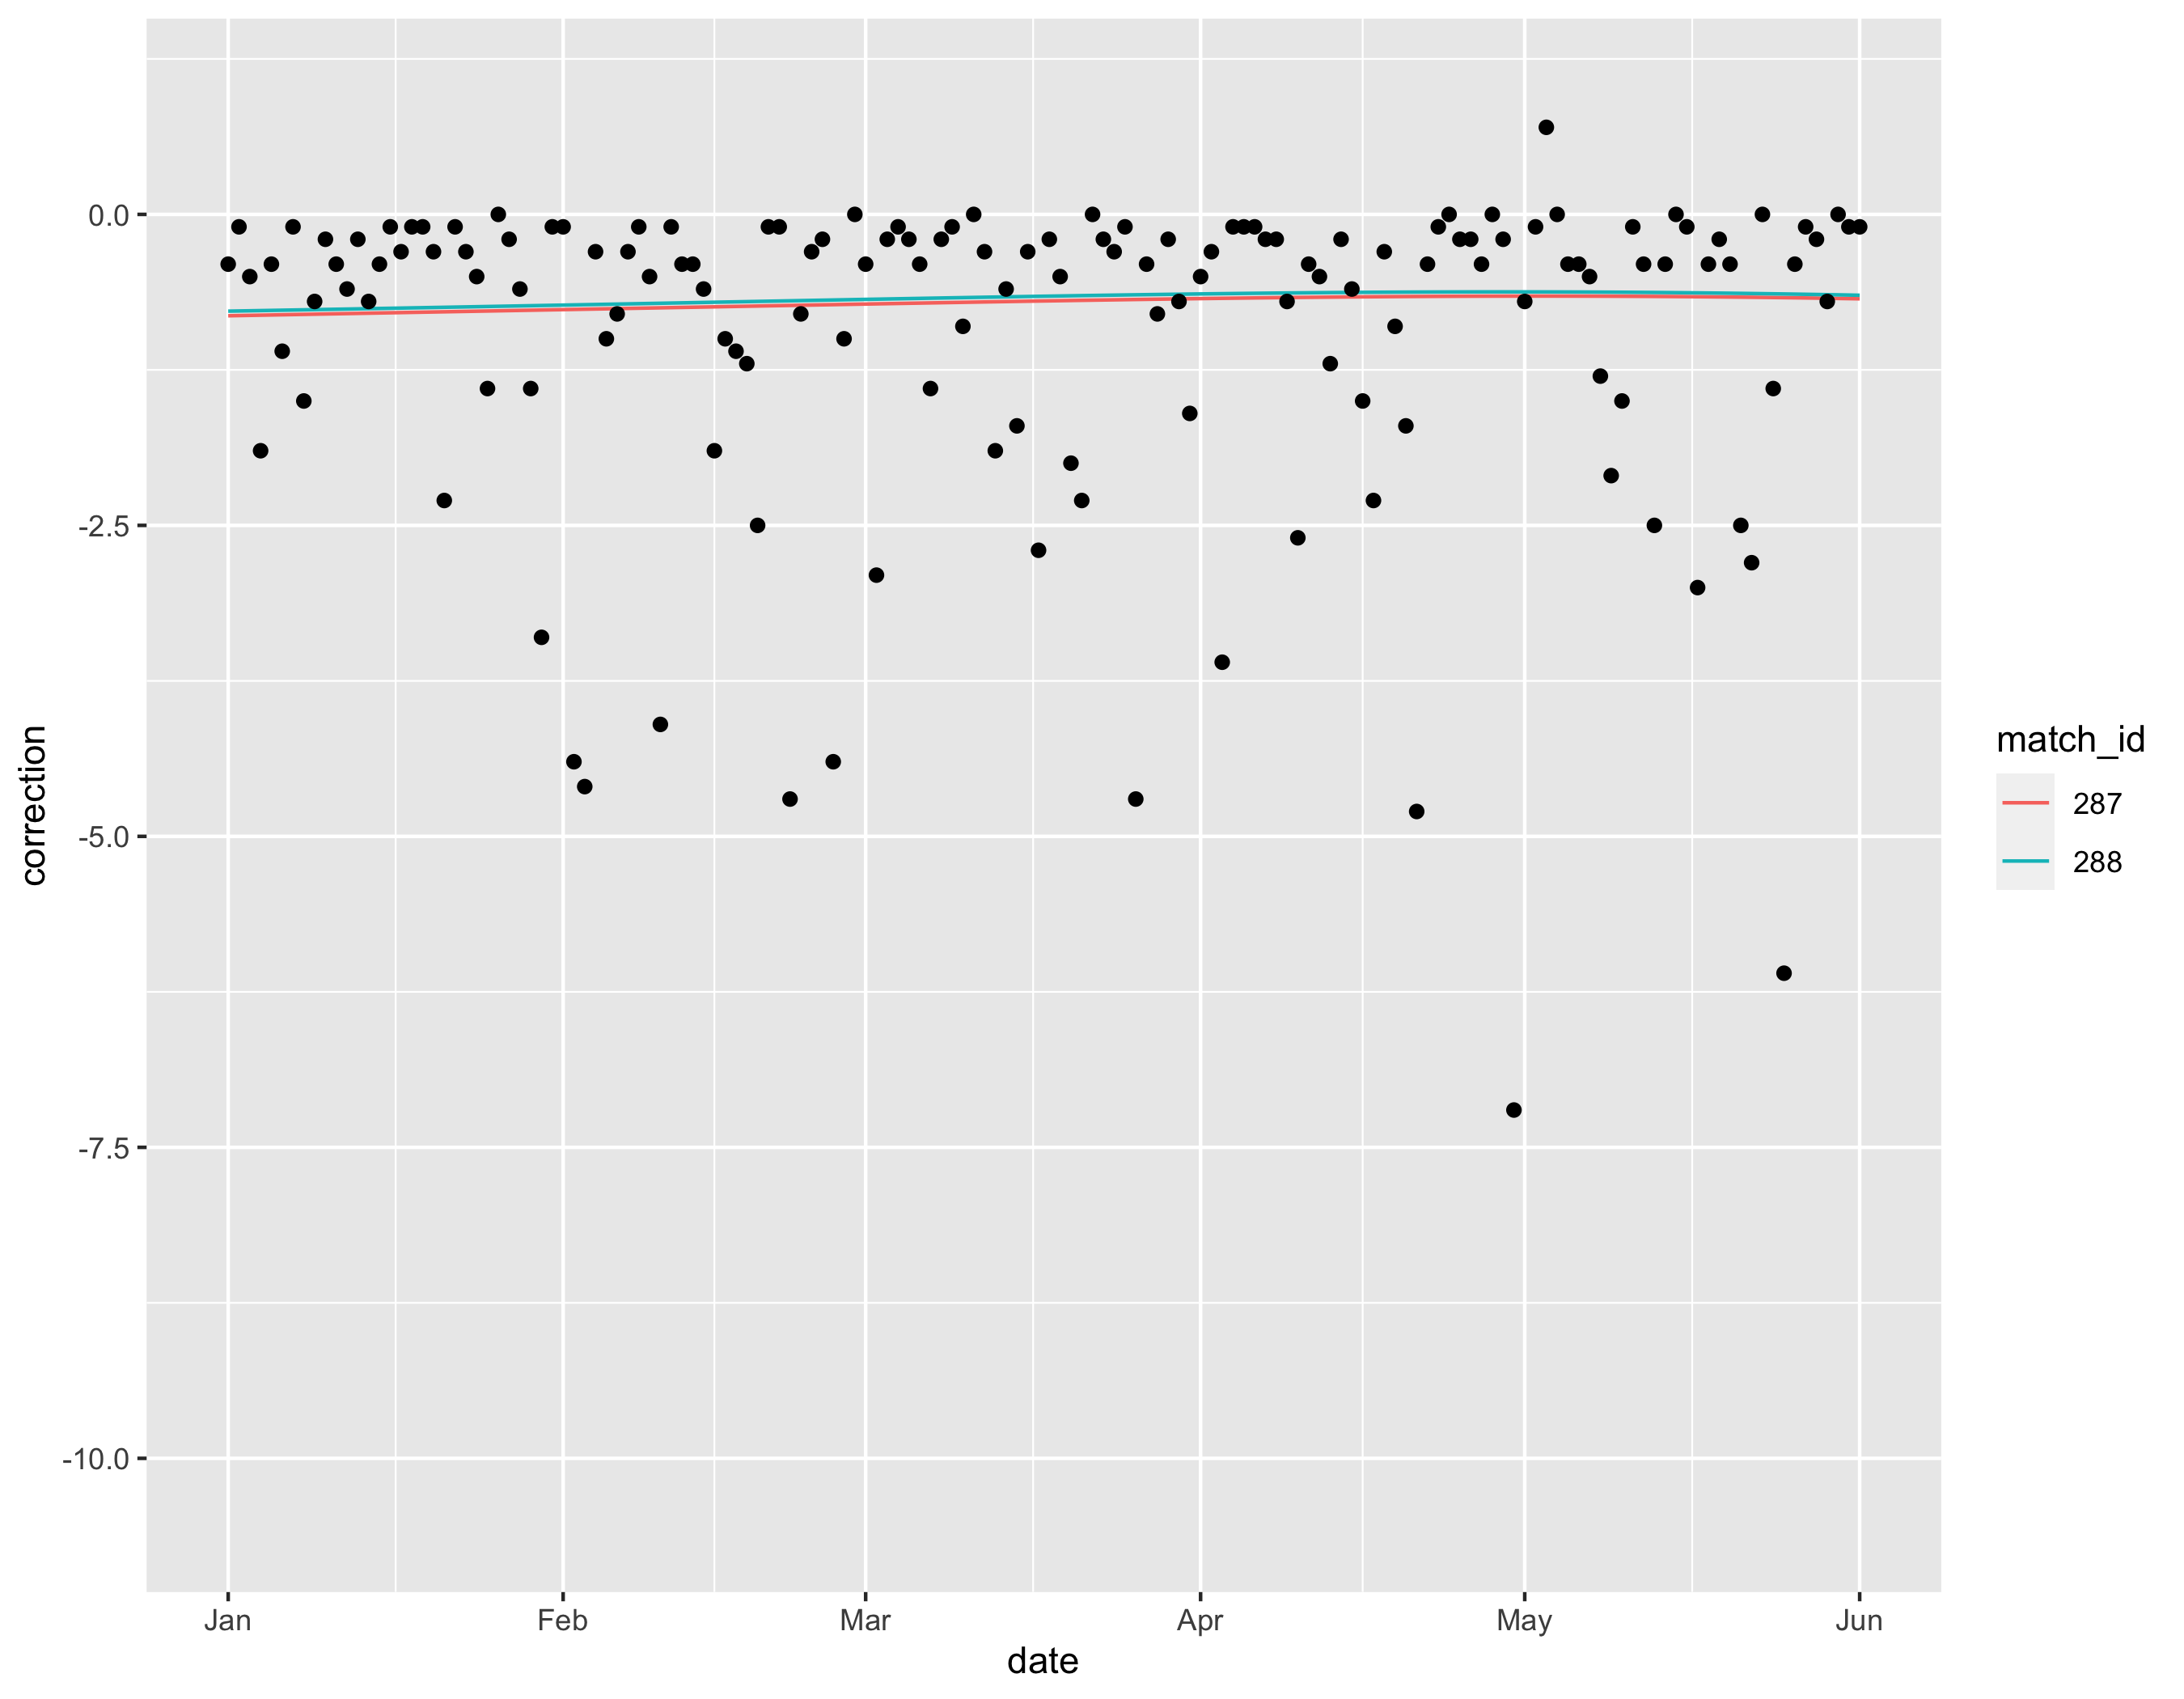

In [130]:
s1 <- emilia |>
    filter(identifier == 192) |>
    collect()
s2 <- data.scia |>
    filter(identifier == 9066, variable == "T_MIN") |>
    collect()
library(tidyr, warn.conflicts = FALSE)
dd <- full_join(s1, s2, c("variable", "date"), suffix = c(".arpae", ".scia")) |>
    select(!starts_with("identifier")) |>
    mutate(diff = value.arpae - value.scia)
corrections |> ggplot() +
    geom_line(aes(date, correction, color = match_id)) +
    geom_point(data = dd |> filter(diff < 1), aes(date, diff)) +
    xlim(as.Date("2010-01-01"), as.Date("2010-06-01"))


Warning message:
"Removed 341 rows containing missing values (`geom_point()`)."


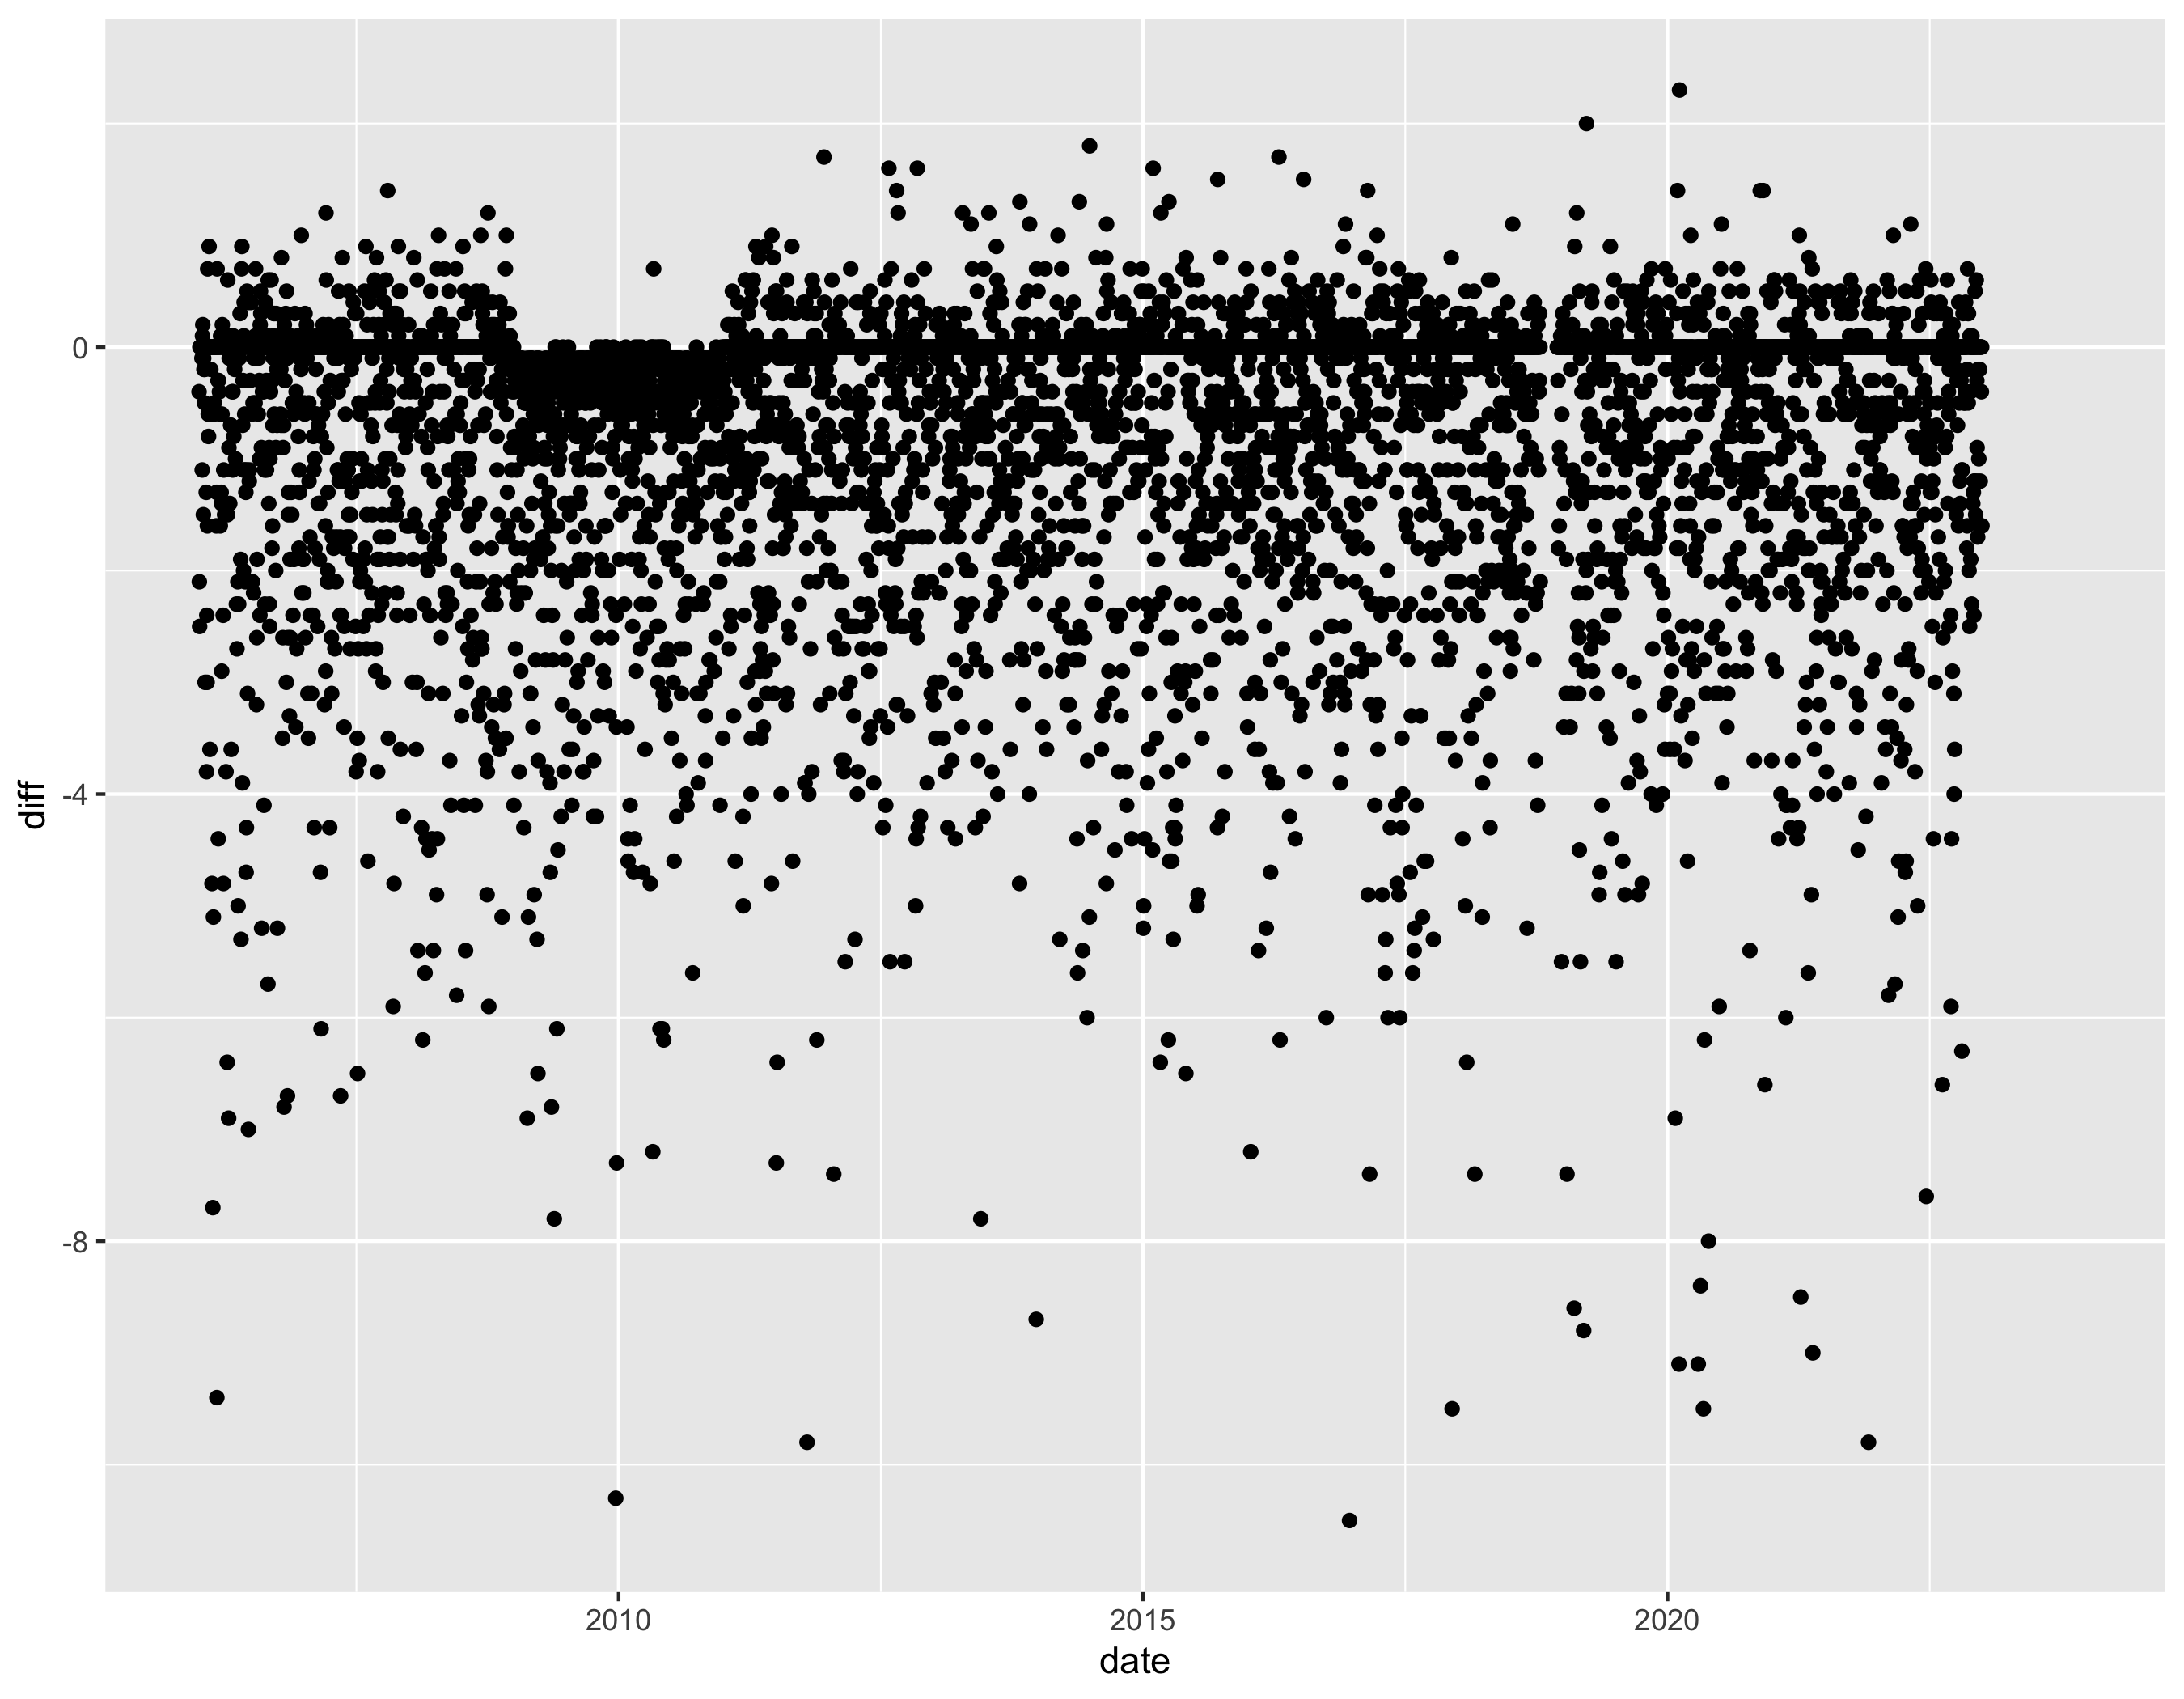

In [125]:
s1 <- emilia |>
    filter(identifier == 192) |>
    collect()
s2 <- data.scia |>
    filter(identifier == 9066, variable == "T_MIN") |>
    collect()
library(tidyr, warn.conflicts = FALSE)
full_join(s1, s2, c("variable", "date"), suffix = c(".arpae", ".scia")) |>
    select(!starts_with("identifier")) |>
    mutate(diff = value.arpae - value.scia) |>
    ggplot(aes(date, diff)) +
    geom_point()
